### Imports

In [1]:
import json
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, Subset

from datasets import SurfaceDatasetXGB

from scipy import stats
from scipy.fft import fft, fftfreq
# from datetime import datetime

from xgboost import XGBClassifier, plot_importance
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier

import warnings
warnings.filterwarnings('ignore')

### Seed

In [2]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

### Constants

In [3]:
DATA_DIR = Path('./Documents/Project_surface_classification/dataset_new/dataset') # TO DO
HISTORY_DIR = Path('./Documents/Project_surface_classification/results') # TO DO
LOOKBACK = 8/3
SAMPLING_FREQUENCY = 75.
DATASET_FREQUENCY = 150.
SUBSET = ('imu',)
CONFIGURATIONS = ('6W',)

### Load and split data

In [4]:
%cd

C:\Users\nwjan


In [5]:
with open('./Documents/Project_surface_classification/labels.json') as fp: # TO DO
    labels = json.load(fp)

In [6]:
dataset = [(DATA_DIR.joinpath(key + '.csv'), values['surface']) for key, values in labels.items() if values['kinematics'] in CONFIGURATIONS and values['spacing'] == 'R1' and 'T1' in values['trajectory']]

In [7]:
X = pd.Series([run[0] for run in dataset], name='bag_name')
y_primary = [run[1] for run in dataset]

In [8]:
# y_secondary = ['slippery' if label in ('1_Panele', '5_Spienione_PCV', '6_Linoleum')
#                else 'grippy' if label in ('3_Wykladzina_jasna', '8_Pusta_plyta', '9_podklady')
#                else 'neutral' for label in y_primary]
y_secondary = ['slippery' if label in ('3_Wykladzina_jasna', '4_Trawa')
               else 'grippy' if label in ('5_Spienione_PCV', '8_Pusta_plyta', '9_podklady', '10_Mata_ukladana')
               else 'neutral' for label in y_primary] # Pawel set
# y_secondary = ['slippery' if label in ('3_Wykladzina_jasna', '4_Trawa')
#                else 'grippy' if label in ('2_Wykladzina_czarna', '5_Spienione_PCV', '9_podklady', '10_Mata_ukladana')
#                else 'neutral' for label in y_primary] # Clustering set

In [9]:
lb = LabelEncoder()
lb.fit(y_primary)
classes = lb.classes_
num_classes = len(classes)
y = lb.transform(y_primary)
# y = y.reshape(-1, num_classes)

### Custom datasets

In [10]:
cv_data = SurfaceDatasetXGB(X, y, sample_freq=SAMPLING_FREQUENCY, data_freq=DATASET_FREQUENCY, lookback=LOOKBACK, subset=SUBSET)

In [11]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 4, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [0.1, 0.5],
    'scale_pos_weight': [1, 2, 3]
}

In [12]:
X.shape, y.shape

((320,), (320,))

### Training loop

In [13]:
history = {}

sss = StratifiedShuffleSplit(test_size=0.2)
for i, (training_index, test_index) in enumerate(sss.split(X, y)):
    
    # Initialize the model in each split
    multi_softmax = XGBClassifier(objective = 'multi:softprob',
                                  num_class=num_classes,
                                  eval_metric=['merror','mlogloss'])
    
    train_subset = Subset(cv_data, training_index)
    test_subset = Subset(cv_data, test_index)

    train_dataloader = DataLoader(train_subset, batch_size=len(train_subset))
    test_dataloader = DataLoader(test_subset, batch_size=len(test_subset))

    X_train, y_train = next(iter(train_dataloader))
    X_test, y_true = next(iter(test_dataloader))
    
    clf_search = RandomizedSearchCV(estimator=multi_softmax, 
                                     param_distributions=param_grid, 
                                     cv=5, scoring='accuracy', n_jobs=-1, verbose=3)

    clf_search.fit(X_train, y_train)
    # y_pred = clf_search.predict(X_test)

    xgb = XGBClassifier(objective = 'multi:softprob',
                        params = clf_search.best_params_,
                        num_class=num_classes,
                        eval_metric=['merror','mlogloss'])

    importances = clf_search.best_estimator_.feature_importances_
    idx = np.argsort(importances) # indexes with highest importance 
    best_features = idx[-25:] # 25 best features
    xgb.fit(X_train[:,best_features], y_train)
    y_pred = xgb.predict(X_test[:,best_features])
    
    history[i + 1] = {'accuracy': accuracy_score(y_true, y_pred), 'f1_score': f1_score(y_true, y_pred, average='macro')}
    # break
history_filename = 'XGB_'+ '_'.join(CONFIGURATIONS + SUBSET) + '_' + time.strftime("%Y-%m-%d-%H-%M-%S")
json.dump(history, open(HISTORY_DIR / f'{history_filename}.json', 'w'))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


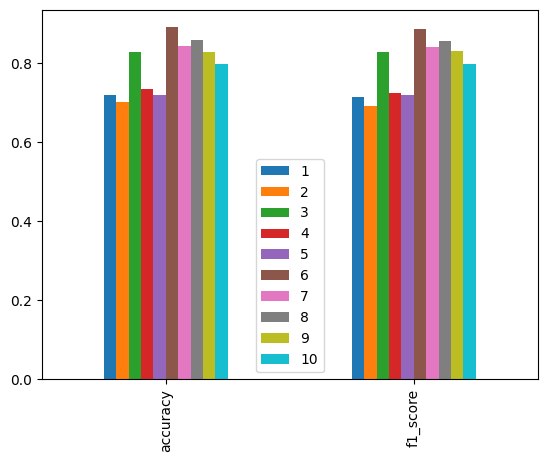

In [15]:
pd.DataFrame(history).plot(kind='bar')
plt.show()

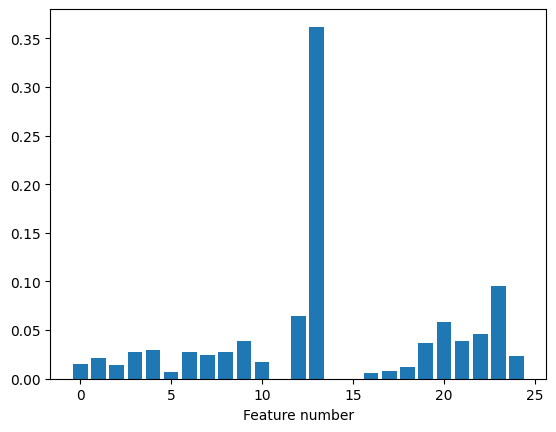

In [30]:
sorted = np.sort(xgb.feature_importances_)
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.xlabel('Feature number')
plt.show()

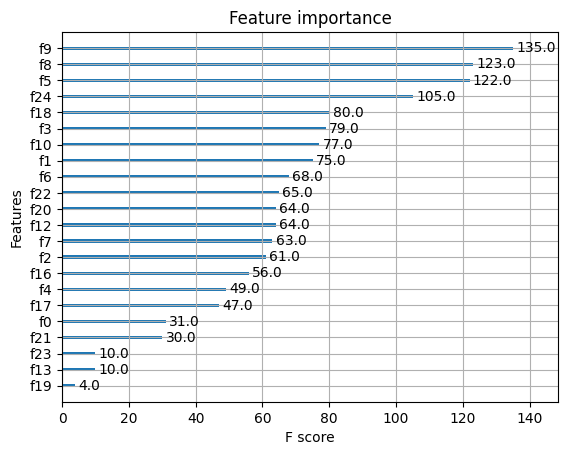

In [17]:
plot_importance(xgb, max_num_features = 25)
plt.show()

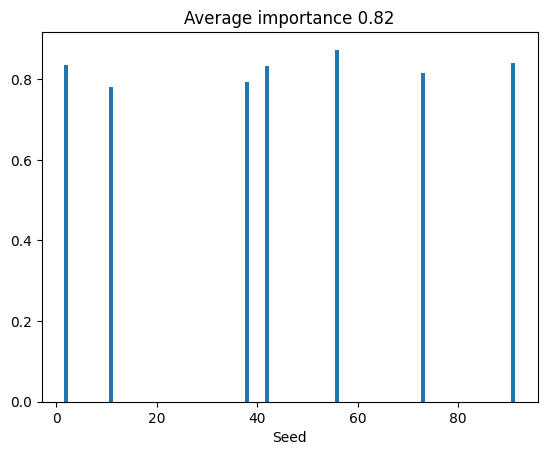

In [28]:
importances = [0.8339781, 0.8319059, 0.78137916, 0.873001, 0.81495255, 0.79207397, 0.8388981]
seeds = [2, 42, 11, 56, 73, 38, 91]
plt.bar(seeds, importances)
plt.xlabel('Seed')
plt.title(f'Average importance {np.mean(importances):0.2f}')
plt.show()